# Imports

In [1]:
import pickle
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pyLDAvis.sklearn
import json
import glob
import os
import pprint
import re
import string
import nltk
import warnings
import networkx as nx
import matplotlib.pyplot as plt
from langdetect import detect
warnings.filterwarnings("ignore",category=DeprecationWarning)

---
# Helper Function - Sweep Tweets

In [2]:
def sweep_tweets(tweets):
    clean_tweets = []
    for tweet in tweets:
        tweet = re.sub(r'[.,"!]+', '', tweet, flags=re.MULTILINE)  # removes the characters specified
        tweet = re.sub(r'^RT[\s]+', '', tweet, flags=re.MULTILINE)  # removes RT
        tweet = re.sub(r'^rt[\s]+', '', tweet, flags=re.MULTILINE)  # removes RT
        tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE)  # remove link https
        tweet = re.sub(r'http?:\/\/.*[\r\n]*', '', tweet, flags=re.MULTILINE)  # remove link http
        tweet = re.sub(r'[:]+', '', tweet, flags=re.MULTILINE)
        tweet=tweet.replace('&amp','').replace(';amp;','')
        tweet = ''.join(filter(lambda x: x in string.printable, tweet))  # filter non-ascii characers

        clean_tweet = ''
        for i in tweet.split():  # remove @words, punctuataion
            if not i.startswith('@') and i not in string.punctuation:
                clean_tweet += i + ' '
        tweet = clean_tweet
        # Do sentence correction
        
        try:
            if detect(tweet) != 'en':
                continue
        except:
            pass
        
        if tweet in clean_tweets:
            continue
        else:
            clean_tweets.append(tweet)
    return clean_tweets

---
# Helper Function - Plot Users and Topics

In [3]:
def convert_to_hex(rgba_color) :
    red = int(rgba_color[0]*255)
    green = int(rgba_color[1]*255)
    blue = int(rgba_color[2]*255)
    return '#%02x%02x%02x' % (red, green, blue)


def plot_users_and_topics(G):
    degree_max = max([G.degree(n) for n, d in G.nodes(data=True) if n and d['type'] == 'user'])
    cmap = plt.cm.summer
    norm = plt.Normalize(vmin=1, vmax=degree_max)
    m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    m._A = []

    post_colors = []
    user_colors = []
    topics = []
    users = []

    node_type = nx.get_node_attributes(G, 'type')
    for node, node_type in node_type.items():
        if node_type == 'topic':
            post_colors.append('red')
            topics.append(node)
        else:
            user_colors.append(convert_to_hex(m.to_rgba(len(G.edges(node)))))
            users.append(node)
    plt.figure(1, figsize=(25,15), dpi=400)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist=topics, node_color=post_colors, with_labels=True, node_shape='^')
    label_dict = {}
    for topic in topics:
        label_dict[topic] = str(topic)
    for user in users:
        label_dict[user] = ''
    nx.draw_networkx_labels(G, pos, labels=label_dict)
    nx.draw_networkx_nodes(G, pos, nodelist=users, node_color=user_colors, with_labels=False, node_shape='o', node_size=100)
    nx.draw_networkx_edges(G, pos)
    plt.colorbar(m)
    plt.title('[ Triangle: Topic, Circle: User (color-by-degree) ]')
    plt.show()

---
# Read Data

In [15]:
BASE_DIR = os.curdir
TWEETS_DIRS = glob.glob(os.path.join(BASE_DIR, 'tweets_*'))
TOPICS = [os.path.split(folder)[1].replace('tweets_', '') for folder in TWEETS_DIRS]
USER_DATA = {}

total_tweets = 0
if os.path.exists(os.path.join(BASE_DIR, 'user_data.pkl')):
    with open(os.path.join(BASE_DIR, 'user_data.pkl'), 'rb') as f:
        USER_DATA = pickle.load(f)
        total_tweets = sum([len(value) for key, value in USER_DATA.items()])
else:
    for tweet_dir in TWEETS_DIRS:
        for json_file in glob.glob(os.path.join(tweet_dir, '*.json')):
            user_data = json.load(open(json_file, 'r'))
            user_id = user_data['user']
            user_tweets = user_data['tweets']
            if user_id not in USER_DATA.keys():
                USER_DATA[user_id] = []
            clean_user_tweets = sweep_tweets(user_tweets)
            USER_DATA[user_id].extend(clean_user_tweets)
            total_tweets += len(clean_user_tweets)

print('--- Data Ingest Summary ---')
print('Users: ' + str(len(USER_DATA.keys())))
print('Tweets: ' + str(total_tweets))
print('Topics: ' + ', '.join(TOPICS))

--- Data Ingest Summary ---
Users: 256
Tweets: 483312
Topics: antivax, illuminati, extraterrestrials, flatearther, haarp, chemtrails, vaccines, conspiracy, pizzagate, hollowearth


In [13]:
with open(os.path.join(BASE_DIR, 'user_data.pkl'), 'wb') as f:
    pickle.dump(USER_DATA, f)

---
# LDA and NMF Setup

In [5]:
# Maximum number of top words to find in the dataset
MAX_FEATURES = 1000

# Max number of topics
N_COMPONENTS = 50

In [6]:
CHEMTRAILS_DIR = os.path.join(BASE_DIR, 'tweets_chemtrails')
CHEMTRAILS_DATA = [json.load(open(json_file, 'r')) for json_file in glob.glob(os.path.join(CHEMTRAILS_DIR, '*.json'))]
CHEMTRAILS_TWEETS = sweep_tweets([tweet for user in CHEMTRAILS_DATA for tweet in user['tweets']])

---
# LDA - Chemtrails Only

In [7]:
chemtrails_tf_vectorizer_lda = CountVectorizer(max_df=0.95, min_df=2, max_features=MAX_FEATURES, stop_words='english')
chemtrails_tf_lda = chemtrails_tf_vectorizer_lda.fit_transform(CHEMTRAILS_TWEETS)

chemtrails_lda = LatentDirichletAllocation(n_components=N_COMPONENTS, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(chemtrails_tf_lda)
chemtrails_topic_vis_lda = pyLDAvis.sklearn.prepare(chemtrails_lda, chemtrails_tf_lda, chemtrails_tf_vectorizer_lda)
pyLDAvis.display(chemtrails_topic_vis_lda)

---
# NMF - Chemtrails Only

In [8]:
chemtrails_tfidf_vectorizer_nmf = TfidfVectorizer(max_df=0.95, min_df=2, max_features=MAX_FEATURES, stop_words='english')
chemtrails_tfidf_nmf = chemtrails_tfidf_vectorizer_nmf.fit_transform(CHEMTRAILS_TWEETS)
chemtrails_tfidf_feature_names_nmf = chemtrails_tfidf_vectorizer_nmf.get_feature_names()

chemtrails_nmf = NMF(n_components=N_COMPONENTS, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(chemtrails_tfidf_nmf)

def display_topics(model, feature_names, no_top_words):
    print()
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(chemtrails_nmf, chemtrails_tfidf_feature_names_nmf, 30)


Topic 0:
people black american white government say believe vote doing truth country use lot said actually power sick young protect really things media dont understand hate million fact away thing money
Topic 1:
new week link order article aircraft service family city tomorrow car book report shows post airpollution airport song followers home 2018 study gold breaking read flight big president released march
Topic 2:
geoengineering lookup wakeup fukushima spraying 17 haarp speakup opchemtrails srm climatechange planet chemicals sun sprayed skies spray 2017 nuclear toxic aerosol clouds weathermodification solar daily 18 aluminum engineering killing climate
Topic 3:
trump president donald maga obama russia mueller hillary america fbi russian says clinton campaign war vote said media comey anti democrats breaking state country national office house retweet michael american
Topic 4:
pollution environment air climatechange clean plastic epa climate cnn oceans environmental shared levels ci

---
# Graph Analysis Setup

In [9]:
G = nx.DiGraph()

for topic in TOPICS:
    G.add_node(topic, type='topic', tweets=[])
    
for user_id, user_tweets in USER_DATA.items():
    G.add_node(user_id, type='user')
    topic_not_found = True
    for tweet in user_tweets:
        for topic in TOPICS:
            if topic in tweet.lower():
                G.add_edge(user_id, topic)
                G.node[topic]['tweets'].append(tweet)
                topic_not_found = False
    if topic_not_found: # Remove nodes with no edges (most-likely filtered due to being non-english)
        G.remove_node(user_id)

---
# Graph Analysis - Users to Topics

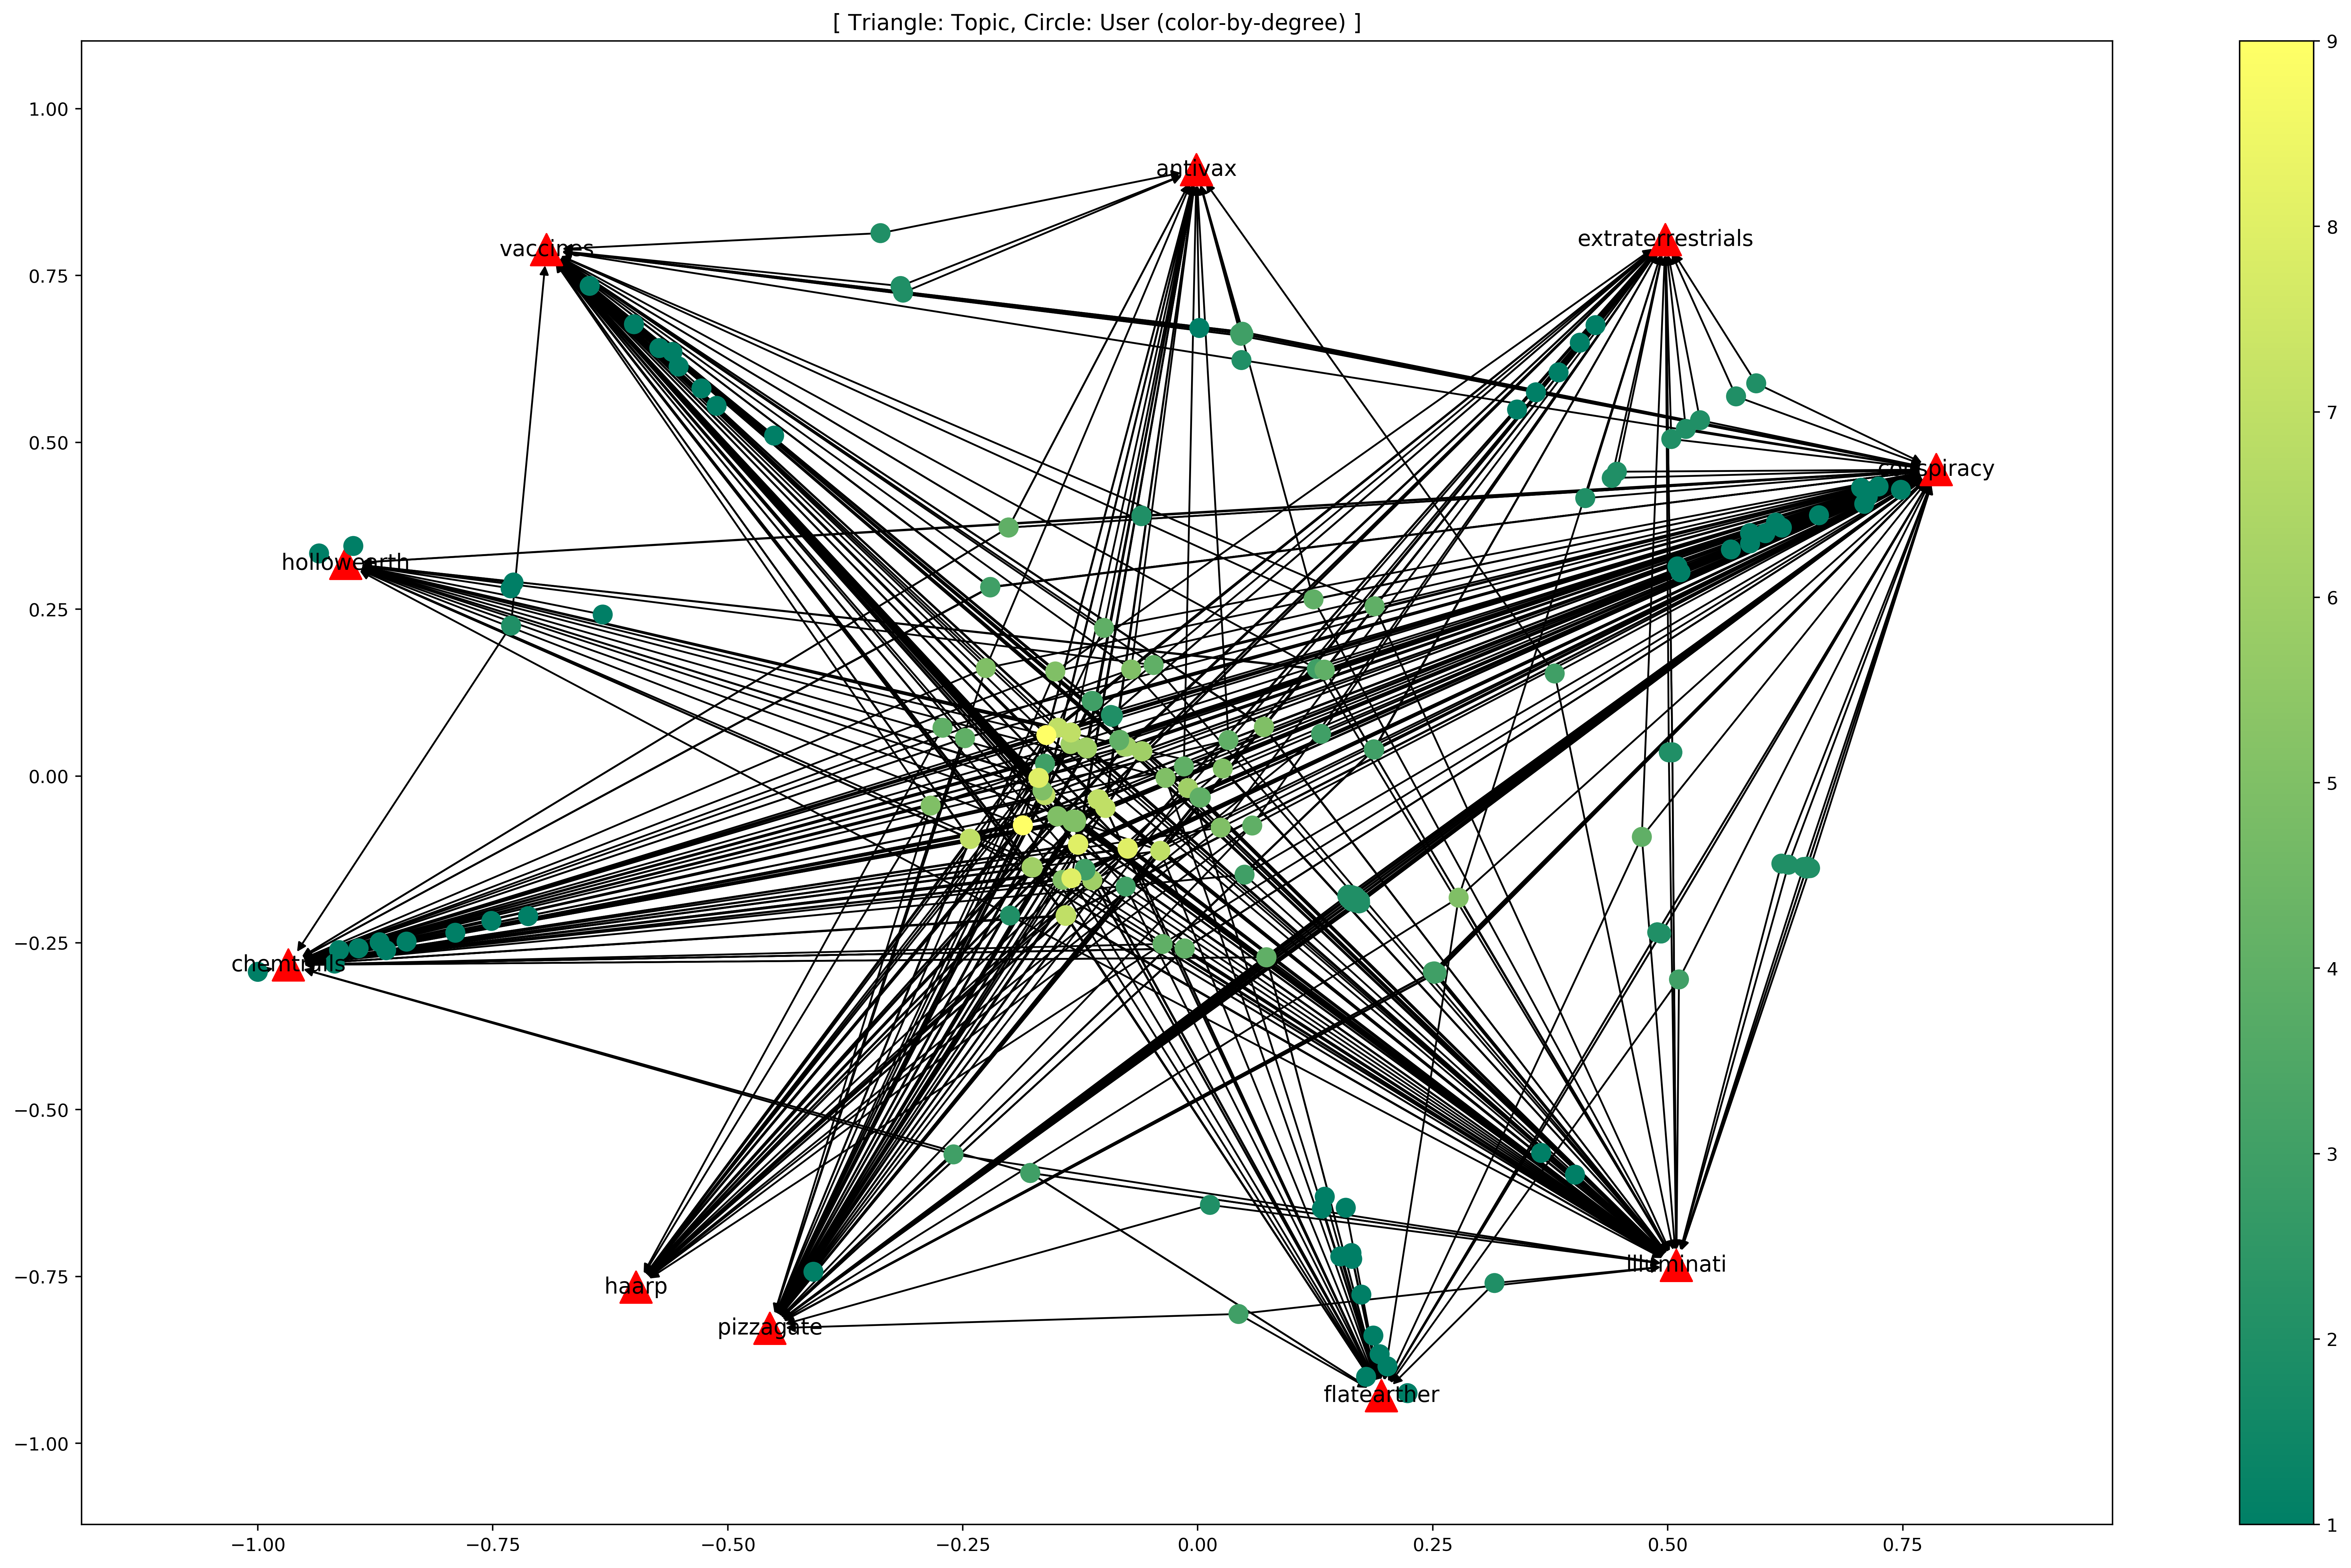

In [10]:
plot_users_and_topics(G)

---
# Graph Analysis - Most Mentioned

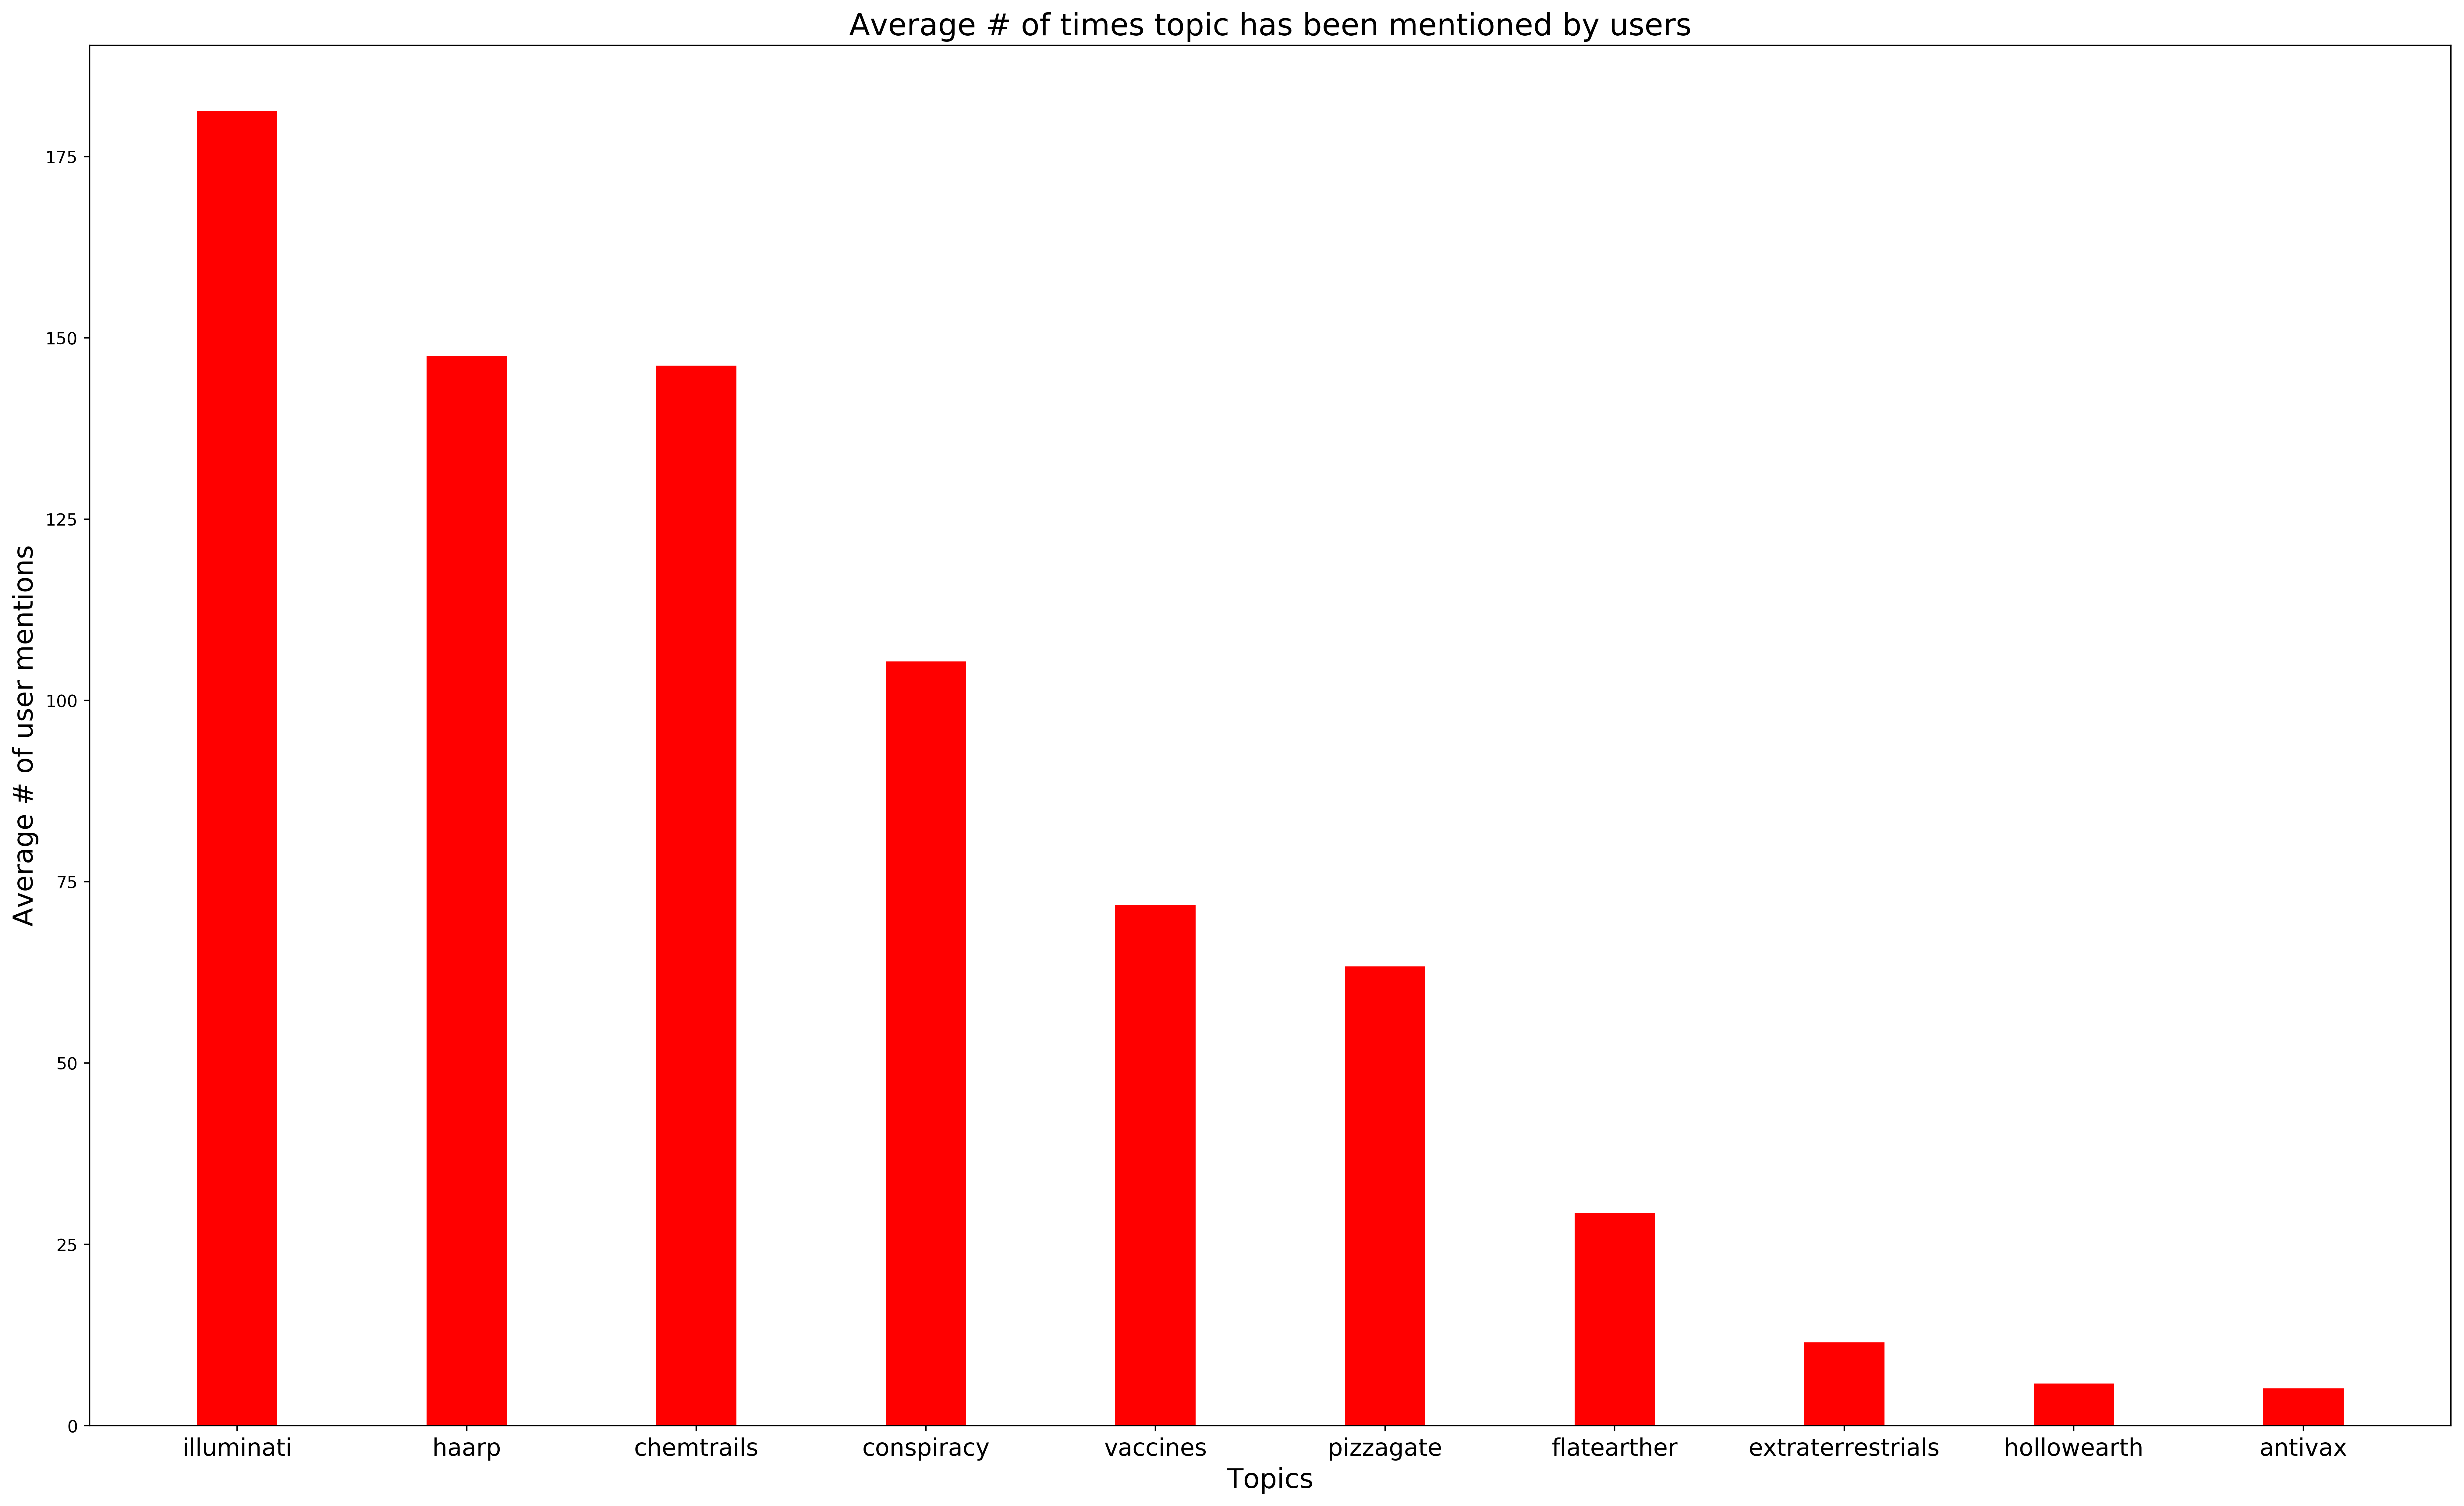

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple


n_groups = len(TOPICS)

avg_mentions = [len(G.node[topic]['tweets'])/len(glob.glob(os.path.join(BASE_DIR, 'tweets_'+topic, '*.json'))) for topic in TOPICS]

sorted_mentions, sorted_topics = zip(*sorted(zip(avg_mentions, TOPICS), reverse=True))

fig, ax = plt.subplots(figsize=(25,15), dpi=400)

index = np.arange(n_groups)
bar_width = 0.35

opacity = 1

rects1 = ax.bar(index, sorted_mentions, bar_width,
                alpha=opacity, color='r',
                label='Topics')


ax.set_xlabel('Topics', fontsize=16)
ax.set_ylabel('Average # of user mentions', fontsize=16)
ax.set_title('Average # of times topic has been mentioned by users', fontsize=18)
ax.set_xticks(index)
ax.set_xticklabels(sorted_topics, fontsize=14)

plt.show()

---
# LDA - All User Tweets

In [12]:
ALL_USER_TWEETS = []
for user_id, user_tweets in USER_DATA.items():
    ALL_USER_TWEETS.extend(user_tweets)

all_user_tf_vectorizer_lda = CountVectorizer(max_df=0.95, min_df=2, max_features=MAX_FEATURES, stop_words='english')
all_user_tf_lda = all_user_tf_vectorizer_lda.fit_transform(ALL_USER_TWEETS)

all_user_lda = LatentDirichletAllocation(n_components=N_COMPONENTS, max_iter=10, learning_method='online', learning_offset=50.,random_state=0).fit(all_user_tf_lda)
all_user_topic_vis_lda = pyLDAvis.sklearn.prepare(all_user_lda, all_user_tf_lda, all_user_tf_vectorizer_lda)
pyLDAvis.display(all_user_topic_vis_lda)